# Homework 06: Decision Trees

So far in this module, we have built a solid foundation in machine learning by focusing on linear regression and addressing a key challenge—the **model selection problem.** We have learned how to choose the right model, measure its performance, and fine-tune its parameters so that the model generalizes well to new data.

This week, we turn our attention to a fundamentally different model: **decision trees.** Unlike regression models, where we typically adjust at most one key parameter (for example, the degree of a polynomial), decision trees have many interacting parameters that can significantly affect performance. As we move from simpler models to more complex ones, it becomes essential to develop a **systematic workflow** for exploring the parameter space and optimizing model performance.

Next week, we will build on this foundation by studying **ensemble methods,** where multiple trees work together to produce even stronger predictive models. These methods will incorporate the parameters we explore this week, along with additional ones, offering even more flexibility in tuning but raising even more challenges in your workflow.

### What We Will Do in This Homework

To identify the best set of parameters for a model with many adjustable settings, there are two main approaches. You can either iterate through the parameters **manually** or use **automated search tools** such as grid search or random search. However, both methods have drawbacks. Manual iteration is time-consuming and exhausting, while automated searches can provide little insight and may not cover the most promising ranges. Exhaustively searching a huge parameter space is often unrealistic.

For these reasons, we will employ a two-phase strategy:

- **First Phase:** Visualize the effect of the most important parameters by plotting and calculating the minimal CV RMSE scores. Adjust the range of the plots to understand how each parameter behaves on its own or in combination with closely related parameters. This phase provides valuable insights, especially in identifying regions where performance is unstable or sensitive to parameter changes.
- **Second Phase:** Focus on the most unstable parameter ranges identified in the first phase and perform an exhaustive search within these ranges to find the optimal model configuration.

The homework is divided into four problems. The first three problems cover the first phase, and the fourth problem addresses the second phase:

- **Problem One:** Tune the size and shape of the decision tree by adjusting `max_depth` and `max_leaf_nodes`.
- **Problem Two:** Explore how the `max_features` parameter can improve performance by effectively performing on-the-fly feature selection during node splits.
- **Problem Three:** Examine how `min_samples_split` influences performance by modifying the criteria for splitting nodes.
- **Problem Four:** Based on the insights gained, use `GridSearchCV` to zero in on the best parameter choices.

Before starting this homework, please review the lesson materials, watch the video, and download the decision tree notebook. This notebook contains code that you will refactor for this assignment—**refactoring existing code is an essential skill in machine learning.**

**Note:** One significant change in this homework compared to previous notebooks is the use of `RepeatedKFold` to reduce the variance of our CV MSE scoring. Further details will be provided below.

### Grading

This homework has eight (8) graded problems, each worth 6 points, and you get 2 points free.

In [1]:
pip install kagglehub

In [2]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold,GridSearchCV
from sklearn.tree            import DecisionTreeRegressor
from sklearn.metrics         import mean_squared_error
from tqdm                    import tqdm

import matplotlib.ticker as mticker           # Optional: you can print out y axis labels as dollars.

# globals

random_state = 42

# utility code

# Completely optional:  Format y-axis labels as dollars with commas
def dollar_format(x, pos):
    return f'${x:,.0f}'

def format_time(seconds):

    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60

    # Return a formatted string
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

### Load the Ames Housing Dataset  

The code cell below will load the dataset for you.  This is the same dataset we used for Homework 05.

> **Notice** that this code includes a useful optimization: **before downloading, it first
checks whether the files already exist.** This is a essential step when working with large datasets or when building deep learning models, where training can span hours or even days. By reusing previously downloaded files or saved models, you can avoid unnecessary work and significantly speed up your workflow.

For a detailed description of the dataset features, please refer to the **Appendix** in Homework 05.

In [3]:

data_dir = "Ames_Dataset"                              # Directory where files will be stored

# Check if one of the files exists; if not, download and extract the zip file

if not os.path.exists( os.path.join(data_dir, "X_train.csv") ):
    print("Dataset files not found. Downloading...")
    zip_url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/ames_housing.zip"
    try:
        response = requests.get(zip_url)
        response.raise_for_status()  # Raise an error for bad status codes
        # Extract the zip file into the designated directory
        with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
            zipf.extractall(data_dir)
        print("Files downloaded and extracted successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("Dataset files already exist. Skipping download.")

# Load the datasets
X_train = pd.read_csv(os.path.join(data_dir, "X_train.csv"))
X_test  = pd.read_csv(os.path.join(data_dir, "X_test.csv"))
y_train = pd.read_csv(os.path.join(data_dir, "y_train.csv")).squeeze("columns")
y_test  = pd.read_csv(os.path.join(data_dir, "y_test.csv")).squeeze("columns")

print("Training and testing datasets loaded successfully.")


Dataset files not found. Downloading...
Files downloaded and extracted successfully.
Training and testing datasets loaded successfully.


## Prelude: Wrapper Function for DecisionTreeRegressor

In the next cell, you'll find the code from the video notebook that wraps together the model, CV scoring, and tree visualization (though visualization is not used in this homework). We made a few minor modifications:

- Expanded the list of parameters to include the full set with default values.
- Employed `RepeatedKFold` to perform 5-fold CV repeated 10 times, yielding 50 MSE scores for averaging instead of just 5.
- Set the default value for `random_state` to 42.
- Set the default value for the `visualize` parameter to `False`.

In [4]:
# Already provided: the code for run_decision_tree_regressor from the video notebook for week 6 with changes as noted

# Wrapper around DecisionTreeRegressor with cross-validation
def run_decision_tree_regressor(X_train,
                                y_train,
                                criterion                = 'squared_error',  # Default parameters for DecisionTreeRegressor
                                splitter                 = 'best',
                                max_depth                = None,
                                min_samples_split        = 2,
                                min_samples_leaf         = 1,
                                min_weight_fraction_leaf = 0.0,
                                max_features             = None,
                                random_state             = 42,               # Not the default, but we'll use it consistently for reproducibility
                                max_leaf_nodes           = None,
                                min_impurity_decrease    = 0.0,
                                ccp_alpha                = 0.0,
                                n_jobs                   = -1,               # Additional parameters for CV and display of plot and results
                                visualize                = False
                               ):

    # Initialize the DecisionTreeRegressor
    decision_tree_model = DecisionTreeRegressor(criterion                = criterion,
                                                splitter                 = splitter,
                                                max_depth                = max_depth,
                                                min_samples_split        = min_samples_split,
                                                min_samples_leaf         = min_samples_leaf,
                                                min_weight_fraction_leaf = min_weight_fraction_leaf,
                                                max_features             = max_features,
                                                random_state             = random_state,
                                                max_leaf_nodes           = max_leaf_nodes,
                                                min_impurity_decrease    = min_impurity_decrease,
                                                ccp_alpha                = ccp_alpha
                                               )

    repeated_cv = RepeatedKFold(random_state=42)    # This will perform 5-fold CV 10 times and return 50 floats instead of 5 as before

    # Perform cross-validation and return mean CV MSE
    neg_mse_scores = cross_val_score(decision_tree_model,
                                     X_train, y_train,
                                     scoring='neg_mean_squared_error',
                                     cv=repeated_cv,
                                     n_jobs=n_jobs)

    mean_cv_mse = -np.mean(neg_mse_scores)  # Convert negative MSE back to positive

    # Train the model on the full training set for visualization purposes
    if visualize:
        decision_tree_model.fit(X_train, y_train)  # Train on full training data for visualization
        plt.figure(figsize=(12, 6))
        plot_tree(decision_tree_model, feature_names=feature_names, filled=True, rounded=True, precision=4)
        plt.title(f"Decision Tree Structure (max_depth={max_depth})")
        plt.show()

    return mean_cv_mse


## Problem One: Controlling the Decision Tree's Shape with `max_depth` and `max_leaf_nodes`

In this problem, you will explore how the structure of a decision tree impacts its performance, using the cross-validated RMSE as the evaluation metric. Answer the following questions:

**A.** How does the baseline model (with default parameters, except for `random_state=42`) perform on the dataset?

**B.** When adjusting only the `max_depth` parameter, which depth produces the lowest CV RMSE?

**C.** When adjusting only the `max_leaf_nodes` parameter, which value results in the best performance?

**D.** Can a combination of `max_depth` and `max_leaf_nodes` yield a lower CV RMSE than optimizing either parameter independently?

For parts **B** and **C**, you will modify the code from the video notebook with minimal changes. For part **D**, you'll use `GridSearchCV` to systematically evaluate various combinations of these two parameters.

### Part 1.A

In the next cell, use `run_decision_tree_regressor` to establish a baseline CV RMSE score for the **training set.** Keep all the parameters at their default.

Note: Make sure you report the RMSE; `run_decision_tree_regressor` returns the MSE.

In [5]:
# Your code here


# Wrapper around DecisionTreeRegressor with cross-validation
def run_decision_tree_regressor(X_train,
                                y_train,
                                criterion                = 'squared_error',
                                splitter                 = 'best',
                                max_depth                = None,
                                min_samples_split        = 2,
                                min_samples_leaf         = 1,
                                min_weight_fraction_leaf = 0.0,
                                max_features             = None,
                                random_state             = 42,
                                max_leaf_nodes           = None,
                                min_impurity_decrease    = 0.0,
                                ccp_alpha                = 0.0,
                                n_jobs                   = -1,
                                visualize                = False,
                                feature_names            = None
                               ):
    # Initialize the DecisionTreeRegressor
    decision_tree_model = DecisionTreeRegressor(criterion                = criterion,
                                                splitter                 = splitter,
                                                max_depth                = max_depth,
                                                min_samples_split        = min_samples_split,
                                                min_samples_leaf         = min_samples_leaf,
                                                min_weight_fraction_leaf = min_weight_fraction_leaf,
                                                max_features             = max_features,
                                                random_state             = random_state,
                                                max_leaf_nodes           = max_leaf_nodes,
                                                min_impurity_decrease    = min_impurity_decrease,
                                                ccp_alpha                = ccp_alpha)

    repeated_cv = RepeatedKFold(random_state=42)

    # Perform cross-validation and return mean CV RMSE
    neg_mse_scores = cross_val_score(decision_tree_model,
                                     X_train, y_train,
                                     scoring='neg_mean_squared_error',
                                     cv=repeated_cv,
                                     n_jobs=n_jobs)

    mean_cv_rmse = np.sqrt(-np.mean(neg_mse_scores))  # Convert to RMSE

    # Train the model on the full training set for visualization purposes
    if visualize:
        decision_tree_model.fit(X_train, y_train)
        plt.figure(figsize=(12, 6))
        plot_tree(decision_tree_model, feature_names=feature_names, filled=True, rounded=True, precision=4)
        plt.title(f"Decision Tree Structure (max_depth={max_depth})")
        plt.show()

    return mean_cv_rmse


In [6]:
baseline_cv_rmse = run_decision_tree_regressor(X_train, y_train)
print(f"Baseline CV RMSE: {baseline_cv_rmse:.4f}")


Baseline CV RMSE: 38773.1748


### Problem 1.A Graded Answer

In [7]:
# TODO:  Set the variable to the baseline CV RMSE score

a1a = 38773.1748                                # Just to get it to run without error; your answer here

print(f'a1a = ${a1a:,.2f}')

a1a = $38,773.17


### Part 1.B

In the next cell, adapt the code from the video notebook to plot CV RMSE vs max_depth with the following modifications:

- Determine an appropriate range of max_depth values that zero in on the optimum. If the best value occurs at either end of your range, it indicates you may not have captured the true minimum—expand your range accordingly.
- Update your plot labels and printout to reflect that you are reporting the root mean square error (RMSE) in dollars. Use the following line in your plotting code to format the Y-axis labels in dollars:
  ```python
  plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
  ```

**Note:** The code in the video notebook may not always use default settings. For this experiment, ensure that all parameters except `max_depth` are set to their default values.

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


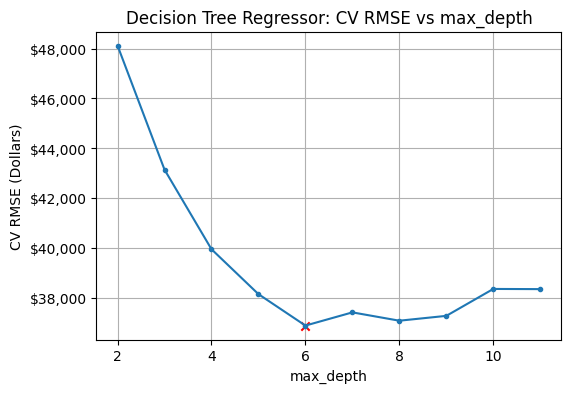

Minimum CV RMSE 36890.02 found at max_depth = 6
Execution Time: 13.92 seconds


In [8]:
# Cut and paste the code from the video notebook to plot and find the best max_depth


# Function to format y-axis as dollars
def dollar_format(x, pos):
    return f"${x:,.0f}"

# Record start time
start = time.time()

param = 'max_depth'

# Test a range of max_depth values
parameter_list = range(2, 12)

# Store RMSE results
RMSEs = []

for d in tqdm(parameter_list):
    rmse = run_decision_tree_regressor(X_train, y_train,
                                       max_depth=d,
                                        max_features=None,
                                             min_samples_split=2,
                                             min_samples_leaf=1,
                                             max_leaf_nodes=None,
                                             criterion='squared_error',
                                             ccp_alpha=0.0,
                                       random_state=42,  # default random state
                                       visualize=False)
    RMSEs.append(rmse)

# Find the minimum RMSE and its index
min_RMSE_max_depth = min(RMSEs)
min_index = RMSEs.index(min_RMSE_max_depth)

# Plotting
plt.figure(figsize=(6, 4))
plt.title("Decision Tree Regressor: CV RMSE vs " + param)
plt.plot(parameter_list, RMSEs, marker='.')
plt.scatter([parameter_list[min_index]], [min_RMSE_max_depth], marker='x', color='red')
plt.xlabel(param)
plt.ylabel("CV RMSE (Dollars)")
plt.grid()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.show()

# Output the minimum RMSE and the best max_depth
print(f"Minimum CV RMSE {min_RMSE_max_depth:.2f} found at max_depth = {parameter_list[min_index]}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: {end - start:.2f} seconds")




### Problem 1.B Graded Answer

In [9]:
# TODO:  Set the variable to the depth found which results in the lowest CV RMSE score

a1b = 6

print(f'a1b = {a1b}')

a1b = 6


### Part 1.C

Now, perform the same experiment as in Part 1.B—but this time, focus on tuning the `max_leaf_nodes` parameter.

**Notes:**

- Ensure that `max_size` is set to `None` so that you can isolate the effect of `max_leaf_nodes` on limiting the size of the tree.
- The range of values for `max_leaf_nodes` will differ considerably from that used for `max_depth`. Experiment with a wide range until you find a minimum that does not occur at either end of your tested interval.

Remember to apply the same modifications as in Part 1.B, including updating your plot labels and printout to reflect that the metric is reported in dollars (using the line below to format the y-axis):

```python
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
```

After generating your plot and results, provide your answer for the graded question.

100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


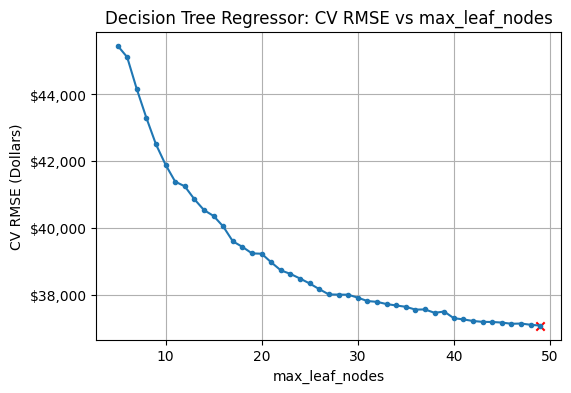

Minimum CV RMSE 37072.77 found at max_leaf_nodes = 49
Execution Time: 55.52 seconds


In [10]:


# Function to format y-axis as dollars
def dollar_format(x, pos):
    return f"${x:,.0f}"

# Record beginning time
start = time.time()

param = 'max_leaf_nodes'

# Wide range of max_leaf_nodes values to test
parameter_list = range(5, 50)

# Store RMSE results
RMSEs = []

for mln in tqdm(parameter_list):
    rmse = run_decision_tree_regressor(X_train, y_train,
                                       max_depth=None,  # Set to None as instructed
                                       max_features=None,  # Default
                                       min_samples_split=2,  # Default
                                       min_samples_leaf=1,  # Default
                                       max_leaf_nodes=mln,  # Parameter under test
                                       criterion='squared_error',  # Default
                                       ccp_alpha=0.0,  # Default
                                       random_state=42,  # Consistent for reproducibility
                                       visualize=False)
    RMSEs.append(rmse)

# Find the minimum RMSE and its index
min_RMSE_max_leaf_nodes = min(RMSEs)
min_index = RMSEs.index(min_RMSE_max_leaf_nodes)

# Plotting
plt.figure(figsize=(6, 4))
plt.title("Decision Tree Regressor: CV RMSE vs " + param)
plt.plot(parameter_list, RMSEs, marker='.')
plt.scatter([parameter_list[min_index]], [min_RMSE_max_leaf_nodes], marker='x', color='red')
plt.xlabel(param)
plt.ylabel("CV RMSE (Dollars)")
plt.grid()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
plt.show()

# Output the minimum RMSE and the best max_leaf_nodes
print(f"Minimum CV RMSE {min_RMSE_max_leaf_nodes:.2f} found at max_leaf_nodes = {parameter_list[min_index]}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: {end - start:.2f} seconds")


### Problem 1.C Graded Answer

In [11]:
# TODO:  Which method provided the best CV score?

a1c =  1 if min_RMSE_max_depth < min_RMSE_max_leaf_nodes else 2                                     # Answer should be 1 = max_depth or 2 = max_leaf_nodes

print(f'a1c = {a1c}')

a1c = 1


### Part 1.D

Limiting the size of a decision tree using `max_depth` (depth) and `max_leaf_nodes` (width) affects the model in different ways. A natural question arises: is there a combination of these two parameters that yields a better score than tuning either one alone?

Because the tradeoff between depth and width might not be clearly captured in a 2D plot, we'll use `GridSearchCV` to systematically explore combinations of values.

**What to Do:**

- In the next cell, write code that uses `GridSearchCV` to search over a grid of values for both max_depth and max_leaf_nodes.
- Use the ranges you explored in Parts 1.B and 1.C, but also include `None` (e.g., `[None] + list(range(2, 18))`) to test whether the default setting is optimal.
- This grid search may take a while to run, depending on your computing resources.
- After the grid search completes, print out the top 10 results. These results will automatically include the MSE and RMSE scores.
- Finally, display the top 10 parameter pairs (combinations of `max_depth` and `max_leaf_nodes`) that produced the best scores.

**NOTE: Make sure you use `RepeatedKFold` for all experiments going forward, unless instructed otherwise.**

Before you start, please review the `GridSearchCV` documentation if you haven't already done so.

In [12]:
# Your code here

# Record start time
start_time = time.time()

# Define the parameter grid
param_grid = {
    'max_depth': [None] + list(range(2, 18)),
    'max_leaf_nodes': [None] + list(range(5, 50))
}

# Initialize the DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=42)

# Use RepeatedKFold for more robust cross-validation
repeated_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=repeated_cv,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract and process the results
results = pd.DataFrame(grid_search.cv_results_)
results['mean_test_rmse'] = np.sqrt(-results['mean_test_score'])  # Convert to RMSE
results = results.sort_values(by='mean_test_rmse')

# Display the top 10 results
top_10 = results.head(10)[['param_max_depth', 'param_max_leaf_nodes', 'mean_test_rmse']]
print("\nTop 10 parameter combinations with the best CV RMSE:\n")
print(top_10)

# Output the best parameters and RMSE
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"\nBest RMSE: {best_rmse:.2f} found at parameters: {best_params}")

# Execution time
execution_time = time.time() - start_time
print(f"\nExecution Time: {execution_time:.2f} seconds")



Top 10 parameter combinations with the best CV RMSE:

    param_max_depth param_max_leaf_nodes  mean_test_rmse
230               6                 None    36890.015327
367               8                   49    37066.496942
413               9                   49    37072.441770
781              17                   49    37072.773465
735              16                   49    37072.773465
459              10                   49    37072.773465
505              11                   49    37072.773465
45             None                   49    37072.773465
551              12                   49    37072.773465
689              15                   49    37072.773465

Best RMSE: 36890.02 found at parameters: {'max_depth': 6, 'max_leaf_nodes': None}

Execution Time: 789.90 seconds


### Problem 1.D Graded Answer

In [13]:
# TODO:  One of these three experiments determined which parameter choices results in the best (lowest) CV RMSE score
#        Set the variable to this best score found so far

a1d =  36890.02                                # Just to get it to run without error; your answer here

print(f'a1d = ${a1d:,.2f}')

a1d = $36,890.02


## Problem Two: Adding Feature Selection and Randomness with max_features

In this problem, you will build on the best model from Problem One by exploring the effect of the `max_features` parameter. This parameter does two key things:

- It performs variable selection at the level of each split by considering only a subset of features (we will revisit this idea in Week 9).
- It randomly chooses this subset at each split, encouraging the model to explore different parts of the feature space. This randomness can improve performance, especially when used with ensemble methods (which we will study next week).

What to Do:

- Use the best model from Problem One and vary only the `max_features` parameter.
- Experiment with a range of values from 1 up to the total number of features in the dataset.
- Print out the plot and the results, and answer the graded question as usual.
- Do not use `GridSearchCV` for this problem.
- Do not reset all parameters to their defaults; keep the best settings from Problem One and only change `max_features`.

In [14]:
best_model_params = {  # Define the best settings from Problem One
    'criterion': 'squared_error',
    'splitter': 'best',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42
}

def run_decision_tree_regressor_with_max_features(X_train,
                                                  y_train,
                                                  best_model_params,
                                                  visualize=False):
    best_max_features = None
    best_score = float('inf')
    feature_range = range(1, X_train.shape[1] + 1)

    results = {}
    for max_features in feature_range:
        model_params = best_model_params.copy()
        model_params['max_features'] = max_features  # Only modify max_features

        decision_tree_model = DecisionTreeRegressor(**model_params)

        repeated_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
        neg_mse_scores = cross_val_score(decision_tree_model, X_train, y_train,
                                         scoring='neg_mean_squared_error', cv=repeated_cv, n_jobs=-1)
        mean_cv_mse = -np.mean(neg_mse_scores)

        results[max_features] = mean_cv_mse

        if mean_cv_mse < best_score:
            best_score = mean_cv_mse
            best_max_features = max_features

    print("Max Features vs. MSE:")
    for k, v in results.items():
        print(f"max_features={k}: MSE={v:.4f}")

    print(f"Best max_features: {best_max_features} with MSE={best_score:.4f}")

    if visualize:
        model_params['max_features'] = best_max_features
        decision_tree_model = DecisionTreeRegressor(**model_params)
        decision_tree_model.fit(X_train, y_train)
        plt.figure(figsize=(12, 6))
        plot_tree(decision_tree_model, filled=True, rounded=True, precision=4)
        plt.title(f"Decision Tree with max_features={best_max_features}")
        plt.show()

    return best_score


### Problem 2 Graded Answer

In [15]:
best_score = run_decision_tree_regressor_with_max_features(X_train, y_train, best_model_params)  # Store the function output


Max Features vs. MSE:
max_features=1: MSE=2932464224.6812
max_features=2: MSE=2692169485.8823
max_features=3: MSE=2344603625.6781
max_features=4: MSE=2044487684.8822
max_features=5: MSE=2098046019.5002
max_features=6: MSE=1996940893.9238
max_features=7: MSE=1912987941.0333
max_features=8: MSE=1921242749.6128
max_features=9: MSE=1804101128.0711
max_features=10: MSE=1725627960.8969
max_features=11: MSE=1839554430.3305
max_features=12: MSE=1804609595.9895
max_features=13: MSE=1764341466.2371
max_features=14: MSE=1758163098.0156
max_features=15: MSE=1750424922.6915
max_features=16: MSE=1741498396.7968
max_features=17: MSE=1675375009.5863
max_features=18: MSE=1630816389.7474
max_features=19: MSE=1590686964.5345
max_features=20: MSE=1601148352.9299
max_features=21: MSE=1583182259.3739
max_features=22: MSE=1578387844.8990
max_features=23: MSE=1623112857.1164
max_features=24: MSE=1617942964.6659
max_features=25: MSE=1543412635.2193
max_features=26: MSE=1565351435.4255
max_features=27: MSE=1465

In [16]:
# TODO:  This *should* have produced an improvement in the score. Assign the variable to this new, improved CV RMSE score

a2 =  np.sqrt(best_score)                                # Just to get it to run without error; your answer here

print(f'a2 = ${a2:,.2f}')

a2 = $37,777.87


## Problem Three: Controlling Node Splitting with min_samples_split

In this problem, you will investigate how the min_samples_split parameter affects your decision tree’s performance. Using the best model configuration obtained from Problems One and Two, vary only the `min_samples_split` parameter while keeping all other parameters fixed.

**What to Do:**

- As before, experiment with different values of `min_samples_split`, starting with a lower bound of 2.
- Plot the CV RMSE against the different values of `min_samples_split` and print out your results.
- Do not use `GridSearchCV` for this experiment.
- Make sure that only the `min_samples_split` parameter is varied; all other parameters should remain at the best settings you’ve found so far.
- Finally, answer the graded question based on your findings.


In [17]:
# Your code here
best_model_params = {  # Define the best settings from Problem One
    'criterion': 'squared_error',
    'splitter': 'best',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42
}


def run_decision_tree_regressor_with_min_samples_split(X_train,
                                                        y_train,
                                                        best_model_params,
                                                        visualize=False):
    best_min_samples_split = None
    best_score = float('inf')
    split_range = range(2, 21)  # Testing values from 2 to 20

    results = {}
    for min_samples_split in split_range:
        model_params = best_model_params.copy()
        model_params['min_samples_split'] = min_samples_split  # Only modify min_samples_split

        decision_tree_model = DecisionTreeRegressor(**model_params)

        repeated_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
        neg_mse_scores = cross_val_score(decision_tree_model, X_train, y_train,
                                         scoring='neg_mean_squared_error', cv=repeated_cv, n_jobs=-1)
        mean_cv_mse = -np.mean(neg_mse_scores)

        results[min_samples_split] = mean_cv_mse

        if mean_cv_mse < best_score:
            best_score = mean_cv_mse
            best_min_samples_split = min_samples_split

    print("Min Samples Split vs. MSE:")
    for k, v in results.items():
        print(f"min_samples_split={k}: MSE={v:.4f}")

    print(f"Best min_samples_split: {best_min_samples_split} with MSE={best_score:.4f}")

    if visualize:
        model_params['min_samples_split'] = best_min_samples_split
        decision_tree_model = DecisionTreeRegressor(**model_params)
        decision_tree_model.fit(X_train, y_train)
        rmse_results = {k: np.sqrt(v) for k, v in results.items()}
        plt.plot(rmse_results.keys(), rmse_results.values(), marker='o')
        plt.xlabel('min_samples_split')
        plt.ylabel('RMSE')
        plt.figure(figsize=(12, 6))
        plot_tree(decision_tree_model, filled=True, rounded=True, precision=4)
        plt.title(f"Decision Tree with min_samples_split={best_min_samples_split}")
        plt.show()

    return best_score





In [18]:
best_score = run_decision_tree_regressor_with_min_samples_split(X_train, y_train, best_model_params)  # Store the function output


Min Samples Split vs. MSE:
min_samples_split=2: MSE=1503359087.1396
min_samples_split=3: MSE=1501667948.2820
min_samples_split=4: MSE=1469503432.9047
min_samples_split=5: MSE=1437768479.1530
min_samples_split=6: MSE=1456359943.3921
min_samples_split=7: MSE=1440052615.1359
min_samples_split=8: MSE=1380431877.1774
min_samples_split=9: MSE=1344448548.5744
min_samples_split=10: MSE=1396734132.8469
min_samples_split=11: MSE=1384427470.6586
min_samples_split=12: MSE=1354031605.2895
min_samples_split=13: MSE=1388493753.4476
min_samples_split=14: MSE=1315001665.9959
min_samples_split=15: MSE=1341743613.5602
min_samples_split=16: MSE=1350162311.3702
min_samples_split=17: MSE=1366035506.9144
min_samples_split=18: MSE=1343871990.5352
min_samples_split=19: MSE=1329760168.7773
min_samples_split=20: MSE=1316358915.0108
Best min_samples_split: 14 with MSE=1315001665.9959


### Problem 3 Graded Answer

In [19]:
# TODO:  Assign the variable to this best CV RMSE score.

a3 = np.sqrt(best_score)                               # Just to get it to run without error; your answer here

print(f'a3 = ${a3:,.2f}')

a3 = $36,262.95


## **Problem Four: Fine-Tuning Your Model**

Now that we have a solid understanding of how our parameters influence model performance, it’s time to refine our search. Instead of testing large parameter ranges blindly, we will **use insights from previous experiments** to focus on the most promising values—balancing accuracy with computational efficiency.

### **Our Strategy**
Rather than searching the entire parameter space, we aim to **narrow down** our grid search to ranges where the optimal model is most likely to be found. The goal is to **eliminate unlikely parameter values** while still thoroughly exploring regions of uncertainty. Consider these two plots:


![Screenshot 2025-02-21 at 4.32.59 PM.png](attachment:290c722e-d32b-40fe-a11f-89abf2304b60.png)


![Screenshot 2025-02-21 at 4.33.12 PM.png](attachment:c7e9469b-0e74-4fbe-91b7-40b0c4b802e4.png)

For example:
- In the first plot, there is a clear performance plateau, so searching outside the highlighted range is likely unnecessary.
- In the second plot, the best region is less obvious, so we could not eliminate any part of the space from consideration.

### **What to Do**
- Using insights from **Problems One through Three**, select **refined parameter ranges** for the three key parameters.
- Perform a **grid search** over these restricted ranges.
- Print out the **top 10 results** as before.
- Summarize your findings and answer the graded questions.


In [20]:
# Your code here
# Define the refined parameter range based on previous results
param_grid = {
    'max_depth': [best_max_depth - 1, best_max_depth, best_max_depth + 1],
    'max_features': [best_max_features - 1, best_max_features, best_max_features + 1],
    'min_samples_split': [best_min_samples_split - 1, best_min_samples_split, best_min_samples_split + 1]
}


# Initialize Decision Tree model
decision_tree = DecisionTreeRegressor(random_state=42)

# Define cross-validation strategy
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(decision_tree, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best models
best_results = sorted(zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']), reverse=True)[:10]

# Print the top 10 models
print("Top 10 Models (Sorted by MSE):")
for score, params in best_results:
    print(f"Params: {params}, MSE: {-score:.4f}")

# Best model
print("\nBest Model Found:")
print(grid_search.best_params_)
print(f"Best MSE: {-grid_search.best_score_:.4f}")


# Extract the best parameters
best_params = grid_search.best_params_
best_score = -grid_search.best_score_



NameError: name 'best_max_depth' is not defined

### Problem 4 Graded Answers

In [ ]:
# TODO:  Set the variable to a triple of the three optimal parameter values found

a4a = (best_params['max_depth'], best_params['max_features'], best_params['min_samples_split'])                           # Your answer should be a triple ( best max_depth, best max_features, best min_samples_split)

print(f'a4a = {a4a}')

a4a = Ellipsis


In [ ]:
# TODO:  Set to the best CV score found by the parameters given in the previous cell.

a4b = best_score                                # Just to get it to run without error; your answer here

print(f'a4b = ${a4b:,.2f}')

a4b = $0.00


## Appendix: Which DecisionTree parameters are most important?

When first exploring  a complex model such as decision trees, it’s best to focus first on those parameters that most directly affect the shape of the tree and the method used for splitting nodes. Some parameters are more important than others, especially when first using a model. Here is an approximate ordering of the parameters from most significant to least. We will only experiment with the first 4 of these parameters in this homework.

---

1. **max_depth** (default: **None**)  
   *Controls the maximum depth of the tree, which is crucial for managing overfitting and overall model complexity.*

2. **max_leaf_nodes** (default: **None**)  
   *An alternative to max_depth, this limits the number of leaf nodes and can be used to control tree size in a different way.*

3. **max_features** (default: **None**)  
   *Determines the maximum number of features considered when looking for the best split. Tuning this can affect the bias-variance trade-off.*

4. **min_samples_split** (default: **2**)  
   *Specifies the minimum number of samples required to split an internal node. It influences how “greedy” the tree is in creating splits.*

---

5. **criterion** (default: **'squared_error'**)  
   *Chooses the function to measure the quality of a split (e.g., squared_error, absolute_error, etc.). Experimenting with this can reveal how different error metrics impact performance.*

6. **splitter** (default: **'best'**)  
   *Decides the strategy used to choose the split at each node (typically "best" or "random"). While its effect is subtler, exploring it can be educational.*

7. **min_samples_leaf** (default: **1**)  
   *Sets the minimum number of samples that must be present in a leaf. This parameter helps prevent creating leaves with very few samples, thus reducing overfitting.*


8. **ccp_alpha** (default: **0.0**)  
   *The complexity parameter for Minimal Cost-Complexity Pruning. It’s useful for understanding pruning techniques, though it’s a bit more advanced.*

9. **min_impurity_decrease** (default: **0.0**)  
   *A node will be split only if the split results in a decrease in impurity greater than or equal to this threshold. It provides another way to control overfitting.*

10. **min_weight_fraction_leaf** (default: **0.0**)  
    *Ensures that each leaf has a minimum weighted fraction of the total. It’s less commonly tuned but can be relevant when sample weights matter.*

11. **random_state** (default: **None**)  
    *Used only for reproducibility, traditionally as `random_state = 42`. It doesn’t affect the model’s learning, but ensures that results are consistent across runs. Set to `None` for more realistic random behavior typical for deployed systems.

